In [1]:
!pip install keras
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install opencv-python
!pip install scikit-learn
!pip install scikit-image
!pip install pandas


In [2]:
!pip install numpy

In [3]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from tensorflow.keras.layers import Concatenate
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import plot_model

import matplotlib.pyplot as plt
import cv2
import string
import time
print("Running.....")

Running.....


In [4]:
token_path = 'Flickr8k/Flickr8k_text/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()
print(text[:500])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7


In [5]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:
            continue
        img_id = token[0].split('.')[0]
        img_des = token[1]
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping

descriptions = load_description(text)
print("Number of items: " + str(len(descriptions)))

Number of items: 8092


In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [8]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words
vocab = to_vocab(descriptions)
len(vocab)

8763

In [9]:
import glob
import os 
images = 'Flickr8k/archive-2/Images'
img = glob.glob(os.path.join(images, '*.jpg'))
len(img)

8091

In [10]:
train_path = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images_set = set(open(train_path, 'r', encoding='utf-8').read().strip().split("\n"))

train_img = []
for im_path in img:
    filename = os.path.basename(im_path)
    if filename in train_images_set:
        train_img.append(im_path)

print(f"Found {len(train_img)} training images.")

Found 6000 training images.


In [11]:
import os 
test_path = 'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
test_images_set = set(open(test_path, 'r', encoding='utf-8').read().strip().split("\n"))
test_img = []
for im_path in img:
    filename = os.path.basename(im_path)
    if filename in test_images_set:
        test_img.append(im_path)

print(f"Found {len(test_img)} test images.")

Found 1000 test images.


In [12]:
# Modified load_clean_descriptions function to handle full image paths
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    # Extract just the filenames from the dataset paths
    dataset_filenames = {os.path.basename(path) for path in dataset}
    
    for key, des_list in des.items():
        if key+'.jpg' in dataset_filenames:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

# Use the updated function
train_descriptions = load_clean_descriptions(descriptions, train_img)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [13]:
# In a new or existing cell:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
from keras.preprocessing.image import load_img, img_to_array
def preprocess_img(img_path):
    img = load_img(img_path, target_size = (299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

In [15]:
base_model = InceptionV3(weights = 'imagenet')
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,851,784 (90.99 MB)

 Trainable params: 23,817,352 (90.86 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [16]:
model = Model(base_model.input, base_model.layers[-2].output)

In [17]:
def encode(image):
    image = preprocess_img(image)
    vec = model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

In [18]:
import numpy as np

In [19]:
start = time.time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time Taken is: " + str(time.time() - start))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

In [20]:
#Encode all the test images
start = time.time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken is: " + str(time.time() - start))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━

In [21]:
train_features = encoding_train
test_features = encoding_test
print("Train image encodings: " + str(len(train_features)))
print("Test image encodings: " + str(len(test_features)))

Train image encodings: 6000
Test image encodings: 1000


In [22]:
# Correct the key to include the leading slash as generated in cell 21
# and print the shape of the feature vector for the specified image.
# This assumes '2638369467_8fc251595b.jpg' is a training image.
key = '/2638369467_8fc251595b.jpg'
if key in train_features:
    print(train_features[key].shape)
else:
    print(f"Key '{key}' not found in train_features.")
    # Optionally, print a few existing keys to help debug
    # print("Example keys:", list(train_features.keys())[:5])

(2048,)


In [23]:
#list of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
len(all_train_captions)

30000

In [24]:
#onsider only words which occur atleast 10 times
vocabulary = vocab
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
print("Unique words: " + str(len(word_counts)))
print("our Vocabulary: " + str(len(vocab)))

Unique words: 7578
our Vocabulary: 1651


In [25]:
#word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

In [26]:
vocab_size = len(ixtoword) + 1  #1 for appended zeros
vocab_size

1652

In [27]:
#find the maximum length of a description in a dataset
max_length = max(len(des.split()) for des in all_train_captions)
max_length

34

In [28]:
#since there are almost 30000 descriptions to process we will use datagenerator
X1, X2, y = list(), list(), list()
# Iterate through each image ID and its list of descriptions in the training set
for key, des_list in train_descriptions.items():
    # Construct the correct key to access the pre-computed image features
    # The keys in train_features include a leading '/' and the '.jpg' extension
    feature_key = '/' + key + '.jpg'
    # Check if the feature key exists in the train_features dictionary
    if feature_key in train_features:
        pic = train_features[feature_key]
        # Process each caption associated with the image
        for cap in des_list:
            # Convert the caption words to their corresponding integer indices using wordtoix mapping
            # Filter out words not present in the vocabulary (wordtoix)
            seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
            # Create input-output pairs for the sequence model
            # For each sequence, generate pairs where the input is the sequence up to index i,
            # and the output is the word at index i
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                # Pad the input sequence to the maximum length
                in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                # Convert the output word index to a one-hot encoded vector
                out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                # Append the image feature, padded input sequence, and one-hot encoded output to the lists
                X1.append(pic)
                X2.append(in_seq)
                y.append(out_seq)
    else:
        # Print a warning if an image feature key is not found (optional, for debugging)
        print(f"Warning: Feature key '{feature_key}' not found in train_features for image ID '{key}'. Skipping.")


# Convert the lists to NumPy arrays for model training
X1 = np.array(X1) # Image features
X2 = np.array(X2) # Padded input sequences
y = np.array(y)   # One-hot encoded output words

# Print the shape of the image features array to verify
print("Shape of X1 (image features):", X1.shape)
print("Shape of X2 (text sequences):", X2.shape)
print("Shape of y (target words):", y.shape)

Shape of X1 (image features): (292328, 2048)
Shape of X2 (text sequences): (292328, 34)
Shape of y (target words): (292328, 1652)


In [29]:
embeddings_index = {}
glove = open('glove.6B.200d.txt', 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    indices = np.asarray(values[1: ], dtype = 'float32')
    embeddings_index[word] = indices
print('Total word vectors: ' + str(len(embeddings_index)))

Total word vectors: 400001


In [30]:
emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
    emb_vec = embeddings_index.get(word)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(1652, 200)

In [31]:
from keras.layers import add # Import the add layer function

# define the model
ip1 = Input(shape = (2048, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
# Use the imported add function
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 200)   │    330,400 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 200)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    467,968 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1652)      │    424,564 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,813,268 (6.92 MB)

 Trainable params: 1,813,268 (6.92 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.layers[2]

<Embedding name=embedding, built=True>

In [33]:
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
plot_model(model, to_file = 'model.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [34]:
for i in range(2):
    model.fit([X1, X2], y, epochs = 1, batch_size = 256)
    if(i%2 == 0):
        model.save_weights("image-caption-weights" + str(i) + ".h5")

1142/1142 ━━━━━━━━━━━━━━━━━━━━ 271s 237ms/step - loss: 4.4677


ValueError: The filename must end in `.weights.h5`. Received: filepath=image-caption-weights0.h5

In [ ]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

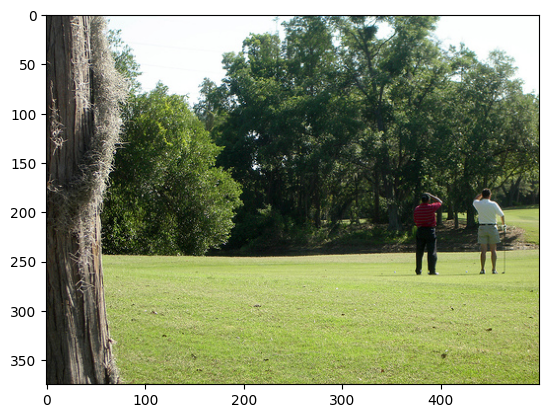

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
two boys are playing in the grass


In [ ]:
pic = list(encoding_test.keys())[201]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

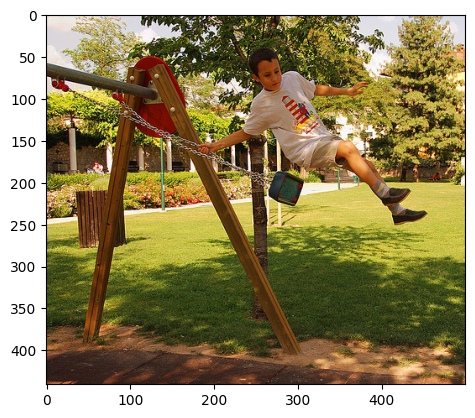

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
boy is jumping on swing


In [ ]:
pic = list(encoding_test.keys())[570]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

In [ ]:
model.save("my_model.h5")

In [ ]:
#train it for some more time
model.fit([X1, X2], y, epochs = 1, batch_size = 64)
model.save("my_model_"+str(i)+".h5")

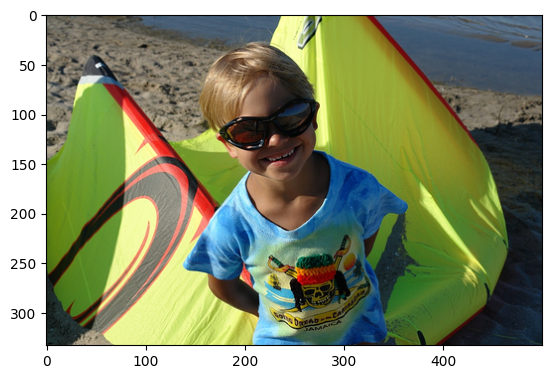

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
man in blue shirt is jumping on the air


In [ ]:
pic = list(encoding_test.keys())[888]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

In [ ]:
model.save("my-cap.h5")

In [ ]:
# Add this to your notebook to create test_references.json

# First, load the test descriptions if not already loaded
test_descriptions = load_clean_descriptions(descriptions, test_images_set)
print(f"Loaded {len(test_descriptions)} test image descriptions")

# Function to prepare references for evaluation
def prepare_test_references(test_descriptions, include_start_end=False):
    """
    Convert test descriptions to the format needed for the GUI BLEU evaluation.
    """
    references = {}
    for img_id, captions in test_descriptions.items():
        clean_captions = []
        for caption in captions:
            if include_start_end:
                clean_captions.append(caption)
            else:
                # Remove startseq and endseq tokens if present
                words = caption.split()
                if words[0] == 'startseq':
                    words = words[1:]
                if words[-1] == 'endseq':
                    words = words[:-1]
                clean_captions.append(' '.join(words))
        # Add .jpg extension to match image filenames in the GUI
        references[img_id + '.jpg'] = clean_captions
    
    return references

# Create the reference file
references = prepare_test_references(test_descriptions)
print(f"Prepared references for {len(references)} test images")

# Save to a JSON file
import json
with open('test_references.json', 'w') as f:
    json.dump(references, f, indent=2)
print("Reference captions saved to test_references.json")

Loaded 1000 test image descriptions
Prepared references for 1000 test images
Reference captions saved to test_references.json
